### Installs

In [1]:
# ! pip install --quiet -U transformers
!pip install --quiet datasets
!pip install --quiet scikit-learn
!pip install --quiet evaluate
!pip install --quiet sentencepiece
!pip install --quiet -U transformers[torch]
! pip install -U accelerate


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 63.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 88.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 31.6 MB/s eta 0:00:00


### Prelimenaries

In [2]:
import gdown

url = "https://drive.google.com/drive/folders/1m8LKDVNj0LCcztrdk-y7dMTY0bs7EQYJ"
gdown.download_folder(url, output="./", quiet=True, use_cookies=False)

['./dataset/test.csv', './dataset/train.csv', './dataset/validation.csv']

In [3]:
base_dir = './dataset/'
data_files = {"train": base_dir + "train.csv", "validation": base_dir + "validation.csv", "test": base_dir + "test.csv"}

In [4]:
! mkdir results

In [5]:
import random
import numpy as np

import torch
import torch.nn as nn
import sys
import os

from datasets import load_dataset

In [6]:
def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

set_seed()

In [7]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [8]:
import logging

# Creating an object
logger = logging.getLogger()

# Setting the threshold of logger to DEBUG
logger.setLevel(logging.INFO)

In [9]:
# General variables
MAX_SEQ_LEN = 128
UNLABELED_BATCH_SIZE = 16
TRAIN_BATCH_SIZE = 16
EVAL_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16
LEARNING_RATE = 2e-5
EPS = 1e-8
LOGGING_STEPS = 50
EVAL_STEPS = 50
D_IN = 768
D_OUT = 4
# epoch * (budget/batch size)
BASE_MODEL = 'xlm-roberta-base'
MAX_STEPS = 500
MAX_STEPS_ = 160
# EPOCHS = int(MAX_STEPS_/TRAIN_BATCH_SIZE)
EPOCHS = 20
MODEL_OUTPUT_DIR = "results/model/"
HEAD_CLASSIFIER_DROP_OUT = 0.1
CLASSIFIER_DROP_OUT = 0.35
CLASSIFIER_HIDDEN_LAYER_SIZE = 10
AUX_CLASSIFIER_HIDDEN_LAYER_SIZE = 10

BUDGET = 750
INITIAL_DATASET_SIZE = 150
ACQUISITION_SIZE = 100
ITERATIONS = int((BUDGET - INITIAL_DATASET_SIZE) / ACQUISITION_SIZE)

print(f"Budget: {BUDGET}")
print(f"Initial Dataset Size: {INITIAL_DATASET_SIZE}")
print(f"Acquisition size: {ACQUISITION_SIZE}")
print(f"Iterations: {ITERATIONS}")

Budget: 750
Initial Dataset Size: 150
Acquisition size: 100
Iterations: 6


In [10]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

### Cross Entorpy Loss

In [11]:
ce_loss = nn.CrossEntropyLoss()

### Create Dataset Embeddings

In [12]:
from datasets import ClassLabel

raw_datasets = load_dataset("csv", data_files=data_files)
label_list = raw_datasets["train"].unique("label")
label_list.sort()

c2l = ClassLabel(num_classes=4, names=label_list)


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [13]:
from torch.utils.data import TensorDataset

def transform_to_embedding_dataset(tokenizer, dataset, is_bert=False):
    input_ids = []
    attention_masks = []
    token_type_ids = []
    labels = []

    for item in dataset:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            item["sentence1"],                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 256,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                    )

        input_ids.append(encoded_dict["input_ids"])
        attention_masks.append(encoded_dict["attention_mask"])
        if is_bert:
            token_type_ids.append(encoded_dict["token_type_ids"])

        labels.append(c2l.str2int(item["label"]))


    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    if is_bert:
        token_type_ids = torch.cat(token_type_ids, dim=0)
    labels = torch.tensor(labels)



    # Combine the training inputs into a TensorDataset.
    if is_bert:
        dataset = TensorDataset(input_ids, attention_masks, token_type_ids, labels)
    else:
        dataset = TensorDataset(input_ids, attention_masks, labels)

    return dataset

In [14]:
task_to_keys = {
    "politics": ("sentence", None),
}

base_dir = './dataset/'

### Model

In [15]:
from transformers import AutoConfig, AutoModel

from transformers import AutoTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup

### Train Loop

In [16]:
from dataclasses import dataclass, field
from typing import Optional

In [17]:
import datasets
from datasets import concatenate_datasets, load_dataset, load_metric
import numpy as np
from datasets import load_dataset

import sys
import os

import evaluate

import transformers
from transformers.trainer_utils import get_last_checkpoint
from transformers import (
    AutoModelForSequenceClassification,
    AutoConfig,
    AutoTokenizer,
    DataCollatorWithPadding,
    EvalPrediction,
    HfArgumentParser,
    PretrainedConfig,
    Trainer,
    TrainingArguments,
    default_data_collator,
    set_seed,
)

INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmpov8_d9sh
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmpov8_d9sh/_remote_module_non_scriptable.py


In [18]:
@dataclass
class DataTrainingArguments:
    """
    Arguments pertaining to what data we are going to input our model for training and eval.
    Using `HfArgumentParser` we can turn this class
    into argparse arguments to be able to specify them on
    the command line.
    """

    task_name: Optional[str] = field(
        default=None,
        metadata={"help": "The name of the task to train on: " + ", ".join(task_to_keys.keys())},
    )
    dataset_name: Optional[str] = field(
        default=None, metadata={"help": "The name of the dataset to use (via the datasets library)."}
    )
    dataset_config_name: Optional[str] = field(
        default=None, metadata={"help": "The configuration name of the dataset to use (via the datasets library)."}
    )
    max_seq_length: int = field(
        default=128,
        metadata={
            "help": (
                "The maximum total input sequence length after tokenization. Sequences longer "
                "than this will be truncated, sequences shorter will be padded."
            )
        },
    )
    overwrite_cache: bool = field(
        default=False, metadata={"help": "Overwrite the cached preprocessed datasets or not."}
    )
    pad_to_max_length: bool = field(
        default=True,
        metadata={
            "help": (
                "Whether to pad all samples to `max_seq_length`. "
                "If False, will pad the samples dynamically when batching to the maximum length in the batch."
            )
        },
    )
    max_train_samples: Optional[int] = field(
        default=None,
        metadata={
            "help": (
                "For debugging purposes or quicker training, truncate the number of training examples to this "
                "value if set."
            )
        },
    )
    max_eval_samples: Optional[int] = field(
        default=None,
        metadata={
            "help": (
                "For debugging purposes or quicker training, truncate the number of evaluation examples to this "
                "value if set."
            )
        },
    )
    max_predict_samples: Optional[int] = field(
        default=None,
        metadata={
            "help": (
                "For debugging purposes or quicker training, truncate the number of prediction examples to this "
                "value if set."
            )
        },
    )

In [19]:
@dataclass
class ModelArguments:
    """
    Arguments pertaining to which model/config/tokenizer we are going to fine-tune from.
    """

    model_name_or_path: str = field(
        metadata={"help": "Path to pretrained model or model identifier from huggingface.co/models"}
    )
    config_name: Optional[str] = field(
        default=None, metadata={"help": "Pretrained config name or path if not the same as model_name"}
    )
    tokenizer_name: Optional[str] = field(
        default=None, metadata={"help": "Pretrained tokenizer name or path if not the same as model_name"}
    )
    cache_dir: Optional[str] = field(
        default=None,
        metadata={"help": "Where do you want to store the pretrained models downloaded from huggingface.co"},
    )
    use_fast_tokenizer: bool = field(
        default=True,
        metadata={"help": "Whether to use one of the fast tokenizer (backed by the tokenizers library) or not."},
    )
    model_revision: str = field(
        default="main",
        metadata={"help": "The specific model version to use (can be a branch name, tag name or commit id)."},
    )
    use_auth_token: bool = field(
        default=False,
        metadata={
            "help": (
                "Will use the token generated when running `huggingface-cli login` (necessary to use this script "
                "with private models)."
            )
        },
    )
    ignore_mismatched_sizes: bool = field(
        default=False,
        metadata={"help": "Will enable to load a pretrained model whose head dimensions are different."},
    )

In [20]:
def experiment(raw_datasets, args_dict=None):
    # See all possible arguments in src/transformers/training_args.py
    # or by passing the --help flag to this script.
    # We now keep distinct sets of args, for a cleaner separation of concerns.

    parser = HfArgumentParser((ModelArguments, DataTrainingArguments, TrainingArguments))
    if args_dict is not None:
        model_args, data_args, training_args = parser.parse_dict(args_dict)
    elif len(sys.argv) == 2 and sys.argv[1].endswith(".json"):
        # If we pass only one argument to the script and it's the path to a json file,
        # let's parse it to get our arguments.
        model_args, data_args, training_args = parser.parse_json_file(json_file=os.path.abspath(sys.argv[1]))
    else:
        model_args, data_args, training_args = parser.parse_args_into_dataclasses()

    # Setup logging
    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        handlers=[logging.StreamHandler(sys.stdout)],
    )

    log_level = training_args.get_process_log_level()
    logger.setLevel(log_level)
    datasets.utils.logging.set_verbosity(log_level)
    transformers.utils.logging.set_verbosity(log_level)
    transformers.utils.logging.enable_default_handler()
    transformers.utils.logging.enable_explicit_format()

    # Log on each process the small summary:
    logger.warning(
        f"Process rank: {training_args.local_rank}, device: {training_args.device}, n_gpu: {training_args.n_gpu}"
        + f"distributed training: {bool(training_args.local_rank != -1)}, 16-bits training: {training_args.fp16}"
    )
    logger.info(f"Training/evaluation parameters {training_args}")

    # Detecting last checkpoint.
    last_checkpoint = None
    if os.path.isdir(training_args.output_dir) and training_args.do_train and not training_args.overwrite_output_dir:
        last_checkpoint = get_last_checkpoint(training_args.output_dir)
        if last_checkpoint is None and len(os.listdir(training_args.output_dir)) > 0:
            raise ValueError(
                f"Output directory ({training_args.output_dir}) already exists and is not empty. "
                "Use --overwrite_output_dir to overcome."
            )
        elif last_checkpoint is not None and training_args.resume_from_checkpoint is None:
            logger.info(
                f"Checkpoint detected, resuming training at {last_checkpoint}. To avoid this behavior, change "
                "the `--output_dir` or add `--overwrite_output_dir` to train from scratch."
            )

    # Set seed before initializing model.
    set_seed(training_args.seed)

    # Labels
    if data_args.task_name is not None:
        is_regression = data_args.task_name == "stsb"
        if not is_regression:
            label_list = raw_datasets["train"].features["label"].names
            num_labels = len(label_list)
        else:
            num_labels = 1
    else:
        # Trying to have good defaults here, don't hesitate to tweak to your needs.
        is_regression = raw_datasets["train"].features["label"].dtype in ["float32", "float64"]
        if is_regression:
            num_labels = 1
        else:
            # A useful fast method:
            # https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Dataset.unique
            label_list = raw_datasets["train"].unique("label")
            label_list.sort()  # Let's sort it for determinism
            num_labels = len(label_list)

    # Load pretrained model and tokenizer
    #
    # In distributed training, the .from_pretrained methods guarantee that only one local process can concurrently
    # download model & vocab.
    logger.info("*** Model Args ***\n")
    logger.info(f"model args{model_args}\n")
    logger.info(f"data {data_args}\n")
    logger.info(f"training {training_args}\n")

    config = AutoConfig.from_pretrained(
        model_args.config_name if model_args.config_name else model_args.model_name_or_path,
        num_labels=num_labels,
        finetuning_task=data_args.task_name,
        cache_dir=model_args.cache_dir,
        revision=model_args.model_revision,
        use_auth_token=True if model_args.use_auth_token else None,
    )
    tokenizer = AutoTokenizer.from_pretrained(
        model_args.tokenizer_name if model_args.tokenizer_name else model_args.model_name_or_path,
        cache_dir=model_args.cache_dir,
        use_fast=model_args.use_fast_tokenizer,
        revision=model_args.model_revision,
        use_auth_token=True if model_args.use_auth_token else None,
    )
    model = AutoModelForSequenceClassification.from_pretrained(
        model_args.model_name_or_path,
        from_tf=bool(".ckpt" in model_args.model_name_or_path),
        config=config,
        cache_dir=model_args.cache_dir,
        revision=model_args.model_revision,
        use_auth_token=True if model_args.use_auth_token else None,
        ignore_mismatched_sizes=model_args.ignore_mismatched_sizes,
    )
    logger.info(f"model {model}\n")
    logger.info(f"config {config}\n")
    logger.info(f"tokenizer {tokenizer}\n")

    # Preprocessing the raw_datasets
    if data_args.task_name is not None:
        sentence1_key, sentence2_key = task_to_keys[data_args.task_name]
    else:
        # Again, we try to have some nice defaults but don't hesitate to tweak to your use case.
        non_label_column_names = [name for name in raw_datasets["train"].column_names if name != "label"]
        if "sentence1" in non_label_column_names and "sentence2" in non_label_column_names:
            sentence1_key, sentence2_key = "sentence1", "sentence2"
        else:
            if len(non_label_column_names) > 2:
                sentence1_key, sentence2_key = non_label_column_names[:2]
            else:
                sentence1_key, sentence2_key = "sentence1", None

    # Padding strategy
    if data_args.pad_to_max_length:
        padding = "max_length"
    else:
        # We will pad later, dynamically at batch creation, to the max sequence length in each batch
        padding = False

    # Some models have set the order of the labels to use, so let's make sure we do use it.
    label_to_id = None
    if (
        model.config.label2id != PretrainedConfig(num_labels=num_labels).label2id
        and data_args.task_name is not None
        and not is_regression
    ):
        # Some have all caps in their config, some don't.
        label_name_to_id = {k.lower(): v for k, v in model.config.label2id.items()}
        if list(sorted(label_name_to_id.keys())) == list(sorted(label_list)):
            label_to_id = {i: int(label_name_to_id[label_list[i]]) for i in range(num_labels)}
        else:
            logger.warning(
                f"""Your model seems to have been trained with labels, but they don't match the dataset:\n
                model labels: {list(sorted(label_name_to_id.keys()))}, dataset labels: {list(sorted(label_list))}.\n
                Ignoring the model labels as a result.""",
            )
    elif data_args.task_name is None and not is_regression:
        label_to_id = {v: i for i, v in enumerate(label_list)}

    if label_to_id is not None:
        model.config.label2id = label_to_id
        model.config.id2label = {id: label for label, id in config.label2id.items()}
    elif data_args.task_name is not None and not is_regression:
        model.config.label2id = {l: i for i, l in enumerate(label_list)}
        model.config.id2label = {id: label for label, id in config.label2id.items()}

    if data_args.max_seq_length > tokenizer.model_max_length:
        logger.warning(
            f"The max_seq_length passed ({data_args.max_seq_length}) is larger than the maximum length for the"
            f"model ({tokenizer.model_max_length}). Using max_seq_length={tokenizer.model_max_length}."
        )
    max_seq_length = min(data_args.max_seq_length, tokenizer.model_max_length)

    def preprocess_function(examples):
        # Tokenize the texts
        args = (
            (examples[sentence1_key],) if sentence2_key is None else (examples[sentence1_key], examples[sentence2_key])
        )
        result = tokenizer(*args, padding=padding, max_length=max_seq_length, truncation=True)

        # Map labels to IDs (not necessary for GLUE tasks)
        if label_to_id is not None and "label" in examples:
            result["label"] = [(label_to_id[l] if l != -1 else -1) for l in examples["label"]]
        return result

    with training_args.main_process_first(desc="dataset map pre-processing"):
        raw_datasets = raw_datasets.map(
            preprocess_function,
            batched=True,
            load_from_cache_file=not data_args.overwrite_cache,
            desc="Running tokenizer on dataset",
        )
    if training_args.do_train:
        if "train" not in raw_datasets:
            raise ValueError("--do_train requires a train dataset")
        train_dataset = raw_datasets["train"]
        if data_args.max_train_samples is not None:
            max_train_samples = min(len(train_dataset), data_args.max_train_samples)
            train_dataset = train_dataset.select(range(max_train_samples))

    if training_args.do_eval:
        if "validation" not in raw_datasets and "validation_matched" not in raw_datasets:
            raise ValueError("--do_eval requires a validation dataset")
        eval_dataset = raw_datasets["validation_matched" if data_args.task_name == "mnli" else "validation"]
        if data_args.max_eval_samples is not None:
            max_eval_samples = min(len(eval_dataset), data_args.max_eval_samples)
            eval_dataset = eval_dataset.select(range(max_eval_samples))

    if training_args.do_predict or data_args.task_name is not None or data_args.test_file is not None:
        if "test" not in raw_datasets and "test_matched" not in raw_datasets:
            raise ValueError("--do_predict requires a test dataset")
        predict_dataset = raw_datasets["test_matched" if data_args.task_name == "mnli" else "test"]
        if data_args.max_predict_samples is not None:
            max_predict_samples = min(len(predict_dataset), data_args.max_predict_samples)
            predict_dataset = predict_dataset.select(range(max_predict_samples))

    # Log a few random samples from the training set:
    if training_args.do_train:
        for index in random.sample(range(len(train_dataset)), 3):
            logger.info(f"Sample {index} of the training set: {train_dataset[index]}.")

    # Get the metric function
    if data_args.task_name is not None:
        metric = evaluate.load("glue", data_args.task_name)
    else:
        metric = evaluate.load("accuracy")

    # You can define your custom compute_metrics function. It takes an `EvalPrediction` object (a namedtuple with a
    # predictions and label_ids field) and has to return a dictionary string to float.
    def compute_metrics(p: EvalPrediction):
        preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
        preds = np.squeeze(preds) if is_regression else np.argmax(preds, axis=1)
        if data_args.task_name is not None:
            result = metric.compute(predictions=preds, references=p.label_ids)
            if len(result) > 1:
                result["combined_score"] = np.mean(list(result.values())).item()
            return result
        elif is_regression:
            return {"mse": ((preds - p.label_ids) ** 2).mean().item()}
        else:
            return {"accuracy": (preds == p.label_ids).astype(np.float32).mean().item()}

    # Data collator will default to DataCollatorWithPadding when the tokenizer is passed to Trainer, so we change it if
    # we already did the padding.
    if data_args.pad_to_max_length:
        data_collator = default_data_collator
    elif training_args.fp16:
        data_collator = DataCollatorWithPadding(tokenizer, pad_to_multiple_of=8)
    else:
        data_collator = None

    # Initialize our Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset if training_args.do_train else None,
        eval_dataset=eval_dataset if training_args.do_eval else None,
        compute_metrics=compute_metrics,
        tokenizer=tokenizer,
        data_collator=data_collator,
    )

    # Training
    if training_args.do_train:
        checkpoint = None
        if training_args.resume_from_checkpoint is not None:
            checkpoint = training_args.resume_from_checkpoint
        elif last_checkpoint is not None:
            checkpoint = last_checkpoint
        train_result = trainer.train(resume_from_checkpoint=checkpoint)
        metrics = train_result.metrics
        max_train_samples = (
            data_args.max_train_samples if data_args.max_train_samples is not None else len(train_dataset)
        )
        metrics["train_samples"] = min(max_train_samples, len(train_dataset))

        trainer.save_model(training_args.output_dir)  # Saves the tokenizer too for easy upload

        trainer.log_metrics("train", metrics)
        trainer.save_metrics("train", metrics)
        trainer.save_state()

    # Evaluation
    evaluation_metrics = {}
    if training_args.do_eval:
        logger.info("*** Evaluate ***")

        # Loop to handle MNLI double evaluation (matched, mis-matched)
        tasks = [data_args.task_name]
        eval_datasets = [eval_dataset]
        if data_args.task_name == "mnli":
            tasks.append("mnli-mm")
            eval_datasets.append(raw_datasets["validation_mismatched"])

        for eval_dataset, task in zip(eval_datasets, tasks):
            metrics = trainer.evaluate(eval_dataset=eval_dataset)

            max_eval_samples = (
                data_args.max_eval_samples
                if data_args.max_eval_samples is not None
                else len(eval_dataset)
            )
            metrics["eval_samples"] = min(max_eval_samples, len(eval_dataset))

            trainer.log_metrics("eval", metrics)
            trainer.save_metrics("eval", metrics)

            evaluation_metrics = metrics

    test_predictions = None
    if training_args.do_predict:
        logger.info("*** Predict ***")

        # Loop to handle MNLI double evaluation (matched, mis-matched)
        tasks = [data_args.task_name]
        predict_datasets = [predict_dataset]
        if data_args.task_name == "mnli":
            tasks.append("mnli-mm")
            predict_datasets.append(raw_datasets["test_mismatched"])

        for predict_dataset, task in zip(predict_datasets, tasks):
            # Removing the `label` columns because it contains -1 and Trainer won't like that.
            predict_dataset = predict_dataset.remove_columns("label")
            test_predictions = trainer.predict(predict_dataset, metric_key_prefix="predict").predictions

    return evaluation_metrics, test_predictions

In [21]:
from tqdm import tqdm
from torch.utils.data import SequentialSampler, DataLoader

def train(train_dataset, validation_dataset, is_bert=False):
    # Creating dataloaders
    logging.info("Creating Dataloaders.")
    train_dataloader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)

    logging.info("Instantiating models.")
    base_model = AutoModel.from_pretrained(BASE_MODEL).to(DEVICE)
    head = nn.Sequential(
            nn.Dropout(HEAD_CLASSIFIER_DROP_OUT),
            nn.Linear(D_IN, CLASSIFIER_HIDDEN_LAYER_SIZE),
            nn.Tanh(),
            nn.Dropout(HEAD_CLASSIFIER_DROP_OUT),
            nn.Linear(CLASSIFIER_HIDDEN_LAYER_SIZE, D_OUT),
        ).to(DEVICE)

    logging.info("Optimizer and Scheduler setup.")
    optimizer = AdamW([
                    {'params': base_model.parameters()},
                    {'params': head.parameters()}
                ], lr=LEARNING_RATE, eps=EPS)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=MAX_STEPS)

    # Start training loop
    logging.info("Training")
    for epoch_i in tqdm(range(EPOCHS)):
        # Print the header of the result table
        print(f"\n{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12}")
        print("-"*45)
        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        base_model.train()
        head.train()

        for step, t_batch in enumerate(train_dataloader):
            batch_counts +=1

            t_batch = tuple(t.to(DEVICE) for t in t_batch)
            if is_bert:
                inputs = {"input_ids": t_batch[0], "attention_mask": t_batch[1], "token_type_ids": t_batch[2]}
            else:
                inputs = {"input_ids": t_batch[0], "attention_mask": t_batch[1]}


            # Update Primary Model
            unfreeze_model(base_model)
            optimizer.zero_grad()

            base_outputs = base_model(**inputs)
            last_hidden_state_cls = base_outputs[0][:, 0, :]
            head_outputs = head(last_hidden_state_cls)

            if is_bert:
                head_loss = ce_loss(head_outputs, t_batch[3])
            else:
                head_loss = ce_loss(head_outputs, t_batch[2])

            head_loss.backward()

            batch_loss += head_loss

            torch.nn.utils.clip_grad_norm_(base_model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

        # Print the loss values and time elapsed for every 20 batches
        if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
            # Print training results
            print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f}")

            # Reset batch tracking variables
            batch_loss, batch_counts = 0, 0

        # After the completion of each training epoch, measure the model's performance
        # on our validation set.
        head_val_loss, head_val_accuracy = evaluate_(base_model, head, validation_dataset)
        logging.info(f"Evaluation Head:: Loss={head_val_loss} Accuracy={head_val_accuracy}")

        return base_model, head

In [22]:
from tqdm import tqdm

def discrepancy_train(train_dataset, validation_dataset, unlabeled_dataset, is_bert=False):
    # Creating dataloaders
    logging.info("Creating Dataloaders.")
    train_dataloader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
    unlabeled_dataloader = DataLoader(unlabeled_dataset, batch_size=UNLABELED_BATCH_SIZE, shuffle=True)

    logging.info("Instantiating models.")
    base_model = AutoModel.from_pretrained(BASE_MODEL).to(DEVICE)
    head = nn.Sequential(
            nn.Dropout(CLASSIFIER_DROP_OUT),
            nn.Linear(D_IN, 50),
            nn.Tanh(),
            nn.Dropout(CLASSIFIER_DROP_OUT),
            nn.Linear(50, 10),
            nn.Tanh(),
            nn.Dropout(CLASSIFIER_DROP_OUT),
            nn.Linear(10, D_OUT),
        ).to(DEVICE)
    classifier1 = nn.Sequential(
            nn.Dropout(CLASSIFIER_DROP_OUT),
            nn.Linear(D_IN, 50),
            nn.Tanh(),
            nn.Dropout(CLASSIFIER_DROP_OUT),
            nn.Linear(50, 10),
            nn.Tanh(),
            nn.Dropout(CLASSIFIER_DROP_OUT),
            nn.Linear(10, D_OUT),
        ).to(DEVICE)
    classifier2 = nn.Sequential(
            nn.Dropout(CLASSIFIER_DROP_OUT),
            nn.Linear(D_IN, 50),
            nn.Tanh(),
            nn.Dropout(CLASSIFIER_DROP_OUT),
            nn.Linear(50, 10),
            nn.Tanh(),
            nn.Dropout(CLASSIFIER_DROP_OUT),
            nn.Linear(10, D_OUT),
        ).to(DEVICE)


    logging.info("Optimizer and Scheduler setup.")
    optimizer = AdamW([
                    {'params': base_model.parameters()},
                    {'params': head.parameters()}
                ], lr=LEARNING_RATE, eps=EPS)
    clf_optimizer = AdamW([
                    {'params': classifier1.parameters()},
                    {'params': classifier2.parameters()}
                ], lr=LEARNING_RATE, eps=EPS)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=MAX_STEPS)

    logging.info("Discrepancy Training")

    for epoch_i in tqdm(range(EPOCHS)):
        # Print the header of the result table
        print(f"\n{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12}")
        print("-"*45)
        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        base_model.train()
        head.train()
        classifier1.train()
        classifier2.train()

        for step, (t_batch, u_batch) in enumerate(zip(train_dataloader, unlabeled_dataloader)):
            batch_counts +=1

            t_batch = tuple(t.to(DEVICE) for t in t_batch)
            if is_bert:
                inputs = {"input_ids": t_batch[0], "attention_mask": t_batch[1], "token_type_ids": t_batch[2]}
            else:
                inputs = {"input_ids": t_batch[0], "attention_mask": t_batch[1]}

            # Update Primary Model
            unfreeze_model(base_model)
            optimizer.zero_grad()

            base_outputs = base_model(**inputs)
            last_hidden_state_cls = base_outputs[0][:, 0, :]
            last_hidden_state_cls_detached = last_hidden_state_cls.detach()
            head_outputs = head(last_hidden_state_cls)

            if is_bert:
                head_loss = ce_loss(head_outputs, t_batch[3])
            else:
                head_loss = ce_loss(head_outputs, t_batch[2])

            head_loss.backward()

            batch_loss += head_loss

            # torch.nn.utils.clip_grad_norm_(base_model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Update Auxlary Models
            freeze_model(base_model)
            clf_optimizer.zero_grad()

            classifier1_outputs = classifier1(last_hidden_state_cls_detached)
            classifier2_outputs = classifier2(last_hidden_state_cls_detached)

            if is_bert:
                classifier1_loss = ce_loss(classifier1_outputs, t_batch[3])
                classifier2_loss = ce_loss(classifier2_outputs, t_batch[3])
            else:
                classifier1_loss = ce_loss(classifier1_outputs, t_batch[2])
                classifier2_loss = ce_loss(classifier2_outputs, t_batch[2])

            classifiers_loss = classifier1_loss + classifier2_loss

            classifiers_loss.backward()
            clf_optimizer.step()


            # Unlabled Data
            u_batch = tuple(t.to(DEVICE) for t in u_batch)
            if is_bert:
                u_inputs = {"input_ids": u_batch[0], "attention_mask": u_batch[1], "token_type_ids": u_batch[2]}
            else:
                u_inputs = {"input_ids": u_batch[0], "attention_mask": u_batch[1]}

            base_outputs = base_model(**u_inputs)
            last_hidden_state_cls = base_outputs[0][:, 0, :].detach()

            head_outputs = head(last_hidden_state_cls)
            classifier1_outputs = classifier1(last_hidden_state_cls)
            classifier2_outputs = classifier2(last_hidden_state_cls)


            base_outputs = base_model(**inputs)
            last_hidden_state_cls = base_outputs[0][:, 0, :]
            last_hidden_state_cls_detached = last_hidden_state_cls.detach()
            classifier1_outputs = classifier1(last_hidden_state_cls_detached)
            classifier2_outputs = classifier2(last_hidden_state_cls_detached)

            if is_bert:
                classifier1_loss = ce_loss(classifier1_outputs, t_batch[3])
                classifier2_loss = ce_loss(classifier2_outputs, t_batch[3])
            else:
                classifier1_loss = ce_loss(classifier1_outputs, t_batch[2])
                classifier2_loss = ce_loss(classifier2_outputs, t_batch[2])
            classifiers_loss = classifier1_loss + classifier2_loss

            loss_dis = classifiers_loss - discrepancy_loss(head_outputs, classifier1_outputs, classifier2_outputs)

            clf_optimizer.zero_grad()
            loss_dis.backward()
            clf_optimizer.step()


        # Print the loss values and time elapsed for every 20 batches
        if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
            # Print training results
            print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f}")

            # Reset batch tracking variables
            batch_loss, batch_counts = 0, 0

        # After the completion of each training epoch, measure the model's performance
        # on our validation set.
        head_val_loss, head_val_accuracy = evaluate_(base_model, head, validation_dataset)
        logging.info(f"Evaluation Head:: Loss={head_val_loss} Accuracy={head_val_accuracy}")
        classifier1_val_loss, classifier1_val_accuracy = evaluate_(base_model, classifier1, validation_dataset)
        logging.info(f"Evaluation Classifier 1:: Loss={classifier1_val_loss} Accuracy={classifier1_val_accuracy}")
        classifier2_val_loss, classifier2_val_accuracy = evaluate_(base_model, classifier2, validation_dataset)
        logging.info(f"Evaluation Classifier 2:: Loss={classifier2_val_loss} Accuracy={classifier2_val_accuracy}")

    return base_model, head, classifier1, classifier2

### Evaluate

In [23]:
def evaluate_(model, classifier, validation_dataset, is_bert=False):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    validation_dataloader = DataLoader(validation_dataset, batch_size=EVAL_BATCH_SIZE, shuffle=True)

    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()
    classifier.eval()

    val_accuracy = []
    val_loss = []

    for _ , batch in enumerate(validation_dataloader):
        batch = tuple(t.to(DEVICE) for t in batch)
        if is_bert:
            inputs = {"input_ids": batch[0], "attention_mask": batch[1], "token_type_ids": batch[2]}
        else:
            inputs = {"input_ids": batch[0], "attention_mask": batch[1]}

        with torch.no_grad():
            outputs = model(**inputs)
            last_hidden_state_cls = outputs[0][:, 0, :]

            logits = classifier(last_hidden_state_cls)

        # Compute loss
        if is_bert:
            loss = ce_loss(logits, batch[3])
        else:
            loss = ce_loss(logits, batch[2])
        val_loss.append(loss.item())
        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()
        # Calculate the accuracy rate
        if is_bert:
            accuracy = (preds == batch[3]).cpu().numpy().mean() * 100
        else:
            accuracy = (preds == batch[2]).cpu().numpy().mean() * 100

        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

### Inference

In [24]:
import torch.nn.functional as F

def performance_check(model, head, test_dataset, classifier1=None, classifier2=None, is_bert=False, is_discrepancy=False):
    test_dataloader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=True)
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    model.eval()
    head.eval()
    if is_discrepancy:
        classifier1.eval()
        classifier2.eval()

    all_head_logits, all_logits1, all_logits2, labels = [], [], [], []

    for batch in test_dataloader:
        batch = tuple(t.to(DEVICE) for t in batch)
        if is_bert:
            inputs = {"input_ids": batch[0], "attention_mask": batch[1], "token_type_ids": batch[2]}
        else:
            inputs = {"input_ids": batch[0], "attention_mask": batch[1]}


        # Compute logits
        with torch.no_grad():
            outputs = model(**inputs)
            last_hidden_state_cls = outputs[0][:, 0, :]

            head_logits = head(last_hidden_state_cls)
            if is_discrepancy:
                logits1 = classifier1(last_hidden_state_cls)
                logits2 = classifier2(last_hidden_state_cls)

        all_head_logits.append(head_logits)

        if is_discrepancy:
            all_logits1.append(logits1)
            all_logits2.append(logits2)

        if is_bert:
            labels.append(batch[3])
        else:
            labels.append(batch[2])



    # Concatenate logits from each batch
    all_head_logits = torch.cat(all_head_logits, dim=0)

    if is_discrepancy:
        all_logits1 = torch.cat(all_logits1, dim=0)
        all_logits2 = torch.cat(all_logits2, dim=0)
    labels = torch.cat(labels, dim=0)

    preds_head = torch.argmax(all_head_logits, dim=1).flatten()
    if is_discrepancy:
        preds1 = torch.argmax(all_logits1, dim=1).flatten()
        preds2 = torch.argmax(all_logits2, dim=1).flatten()
        return preds_head, preds1, preds2, labels
    else:
        return preds_head, labels

### Metric Report

In [25]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

def report(preds, labels):
    print("Metrics Report:\n")
    print(f"Accuracy: {accuracy_score(labels, preds)}")
    print(f"Confusion Matrix:\n{confusion_matrix(labels, preds)}")
    print(f"Precision: {precision_score(labels, preds,average='weighted')}")
    print(f"Recall: {recall_score(labels, preds,average='weighted')}")
    print(f"F1-score: {f1_score(labels, preds, average='weighted')}")

### Discrepancy Loss

In [26]:
l1 = nn.L1Loss()

In [27]:
def discrepancy_loss(logits1, logits2, logits3):
    def discrepancy(outputs1, outputs2):
        return l1(outputs1, outputs2)
    dis1 = discrepancy(logits1, logits2)
    dis2 = discrepancy(logits1, logits3)
    dis3 = discrepancy(logits2, logits3)
    loss = (dis1+dis2+dis3) / 3
    return loss

In [28]:
a = torch.Tensor([[-0.6909,  1.1088], [-0.3, 10]])
b = torch.Tensor([-0.6909,  1.1188])
c = torch.Tensor([-0.6909,  1.1188])
# discrepancy_loss(a, b, c)
nn.functional.normalize(a,dim=0)
nn.functional.softmax(a,dim=0)

tensor([[4.0350e-01, 1.3758e-04],
        [5.9650e-01, 9.9986e-01]])

### Disagreement Score

In [29]:
l1_none = nn.MSELoss(reduction='none')
# ce = nn.(reduction='none')

In [30]:
def normalize(logits):
  normal_logits = logits
  normal_logits = nn.functional.normalize(normal_logits,2,dim=1)
  normal_logits = nn.functional.softmax(normal_logits,dim=1)
  return normal_logits

In [31]:
def disagreement_score(logits1, logits2, logits3):
    normal_logits1 = normalize(logits1)
    normal_logits2 = normalize(logits2)
    normal_logits3 = normalize(logits3)
    def disagreement(outputs1, outputs2):
        return torch.sum(l1_none(outputs1, outputs2), dim=-1)
    disagreement_score = (disagreement(normal_logits1, normal_logits2) + disagreement(normal_logits1, normal_logits3) + disagreement(normal_logits2, normal_logits3)) / 3
    return disagreement_score

In [32]:
a = torch.Tensor([[1.0,  0.0]])
b = torch.Tensor([[2.0,  1.0]])
c = torch.Tensor([[1.0,  3.0]])
disagreement_score(a, b, c)

tensor([0.1543])

### Active Learning

In [33]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

def calculate_disagreement_score(model, test_dataset, head, classifier1=None, classifier2=None, is_bert=False):
    test_dataloader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    model.eval()
    head.eval()
    classifier1.eval()
    classifier2.eval()

    scores = []

    for batch in test_dataloader:
        batch = tuple(t.to(DEVICE) for t in batch)
        if is_bert:
            inputs = {"input_ids": batch[0], "attention_mask": batch[1], "token_type_ids": batch[2]}
        else:
            inputs = {"input_ids": batch[0], "attention_mask": batch[1]}

        with torch.no_grad():
            outputs = model(**inputs)
            last_hidden_state_cls = outputs[0][:, 0, :]

            head_logits = head(last_hidden_state_cls)
            logits1 = classifier1(last_hidden_state_cls)
            logits2 = classifier2(last_hidden_state_cls)

            scores.append(disagreement_score(head_logits, logits1, logits2))

    scores = torch.cat(scores)
    bins = 100
    hist = torch.histc(scores.cpu(), bins=bins)
    hist = hist.div(hist.sum())
    x = range(bins)
    plt.bar(x, hist, align='center')
    plt.show()
    plt.boxplot(scores.cpu())
    plt.show()
    return torch.Tensor(scores)

In [34]:
def annotate(unlabled_samples):
    return unlabled_samples

In [35]:
def get_label_predictions(predicted, raw_dataset):
  t = transform_to_embedding_dataset(tokenizer, raw_datasets["test"])
  labels = t[:][2]
  predicted_tensor = torch.argmax(torch.tensor(predicted), dim=1).flatten()
  return predicted_tensor.cpu().numpy(), labels.cpu().numpy()

In [36]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from datasets import concatenate_datasets
import gc

def discrepancy_active_learning(
        hf_args,
        raw_datasets,
        initial_labeled_dataset_size,
        iteration_count,
        iteration_sample_count,
        candidate_to_selected_samples_ratio=10
    ):

    tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, do_lower_case=True)

    original_train_dataset = raw_datasets["train"]

    # select initial train dataset from raw dataset
    train_dataset = original_train_dataset.select(
        random.sample(
            range(original_train_dataset.num_rows),
            initial_labeled_dataset_size,
        )
    )

    unlabeled_dataset = original_train_dataset.filter(
        lambda s: s["idx"] not in train_dataset["idx"]
    )

    raw_datasets["train"] = train_dataset
    # Train Initial Model
    logger.info(f'Initial Training with {raw_datasets["train"].num_rows} samples.')

    evaluation_metrics, test_predictions = experiment(raw_datasets, args_dict=hf_args)

    print(f"*** predictions: {test_predictions}")
        # logging.info(f"*** test data: {len(raw_dataset['test'])}")
    print(f"*** predictions_len data: {len(test_predictions)}")
    head_preds, labels = get_label_predictions(test_predictions, raw_datasets)
    report(head_preds, labels)

    # train_labeled = transform_to_embedding_dataset(tokenizer, raw_datasets["train"], is_bert=False)
    # validation_labeled = transform_to_embedding_dataset(tokenizer, raw_datasets["validation"], is_bert=False)
    # model, head = train(train_dataset=train_labeled, validation_dataset=validation_labeled)

    # test_labeled = transform_to_embedding_dataset(tokenizer, raw_datasets["test"], is_bert=False)
    # head_preds, labels = performance_check(
    #     model=model,
    #     head=head,
    #     test_dataset=test_labeled
    # )
    # report(head_preds.cpu().numpy(), labels.cpu().numpy())
    # del model
    # del head
    # gc.collect()
    torch.cuda.empty_cache()

    current_iteration = 1
    while  current_iteration <= iteration_count:
        print(f'Current Active Learning Iteration: {current_iteration}')

        if unlabeled_dataset.num_rows <= 0:
            logger.info(f'Not enough unlabeled data to continue. Stoped at iteration {current_iteration}')

        # Sample candidate_to_selected_samples_ratio larger than iteration_sample_count sample for acquisition function
        candidate_count = int(len(raw_datasets["train"]))
        # candidate_count = int(candidate_to_selected_samples_ratio * iteration_sample_count)

        logger.info(f"Candidate samples count for active learning : {candidate_count}")
        candidate_samples = unlabeled_dataset.select(
            random.sample(
                range(unlabeled_dataset.num_rows),
                candidate_count,
            )
        )


        # Acquisition Function - Discrepancy Strategy

        # active_learning_data = datasets.DatasetDict({"train":candidate_samples, "test":candidate_samples})
        # hf_args["do_train"] = False
        # hf_args["do_eval"] = False
        # hf_args["do_predict"] = True
        # hf_args["evaluation_strategy"] = "no"
        # del(hf_args["load_best_model_at_end"])
        # _, candidate_test_predictions = experiment(active_learning_data, args_dict=hf_args)
        # sample_margins = calculate_breaking_ties(candidate_test_predictions)
        # chosen_samples = torch.topk(sample_margins, iteration_sample_count)

        model = AutoModel.from_pretrained(BASE_MODEL).to(DEVICE)
        train_labeled = transform_to_embedding_dataset(tokenizer, raw_datasets["train"], is_bert=False)
        validation_labeled = transform_to_embedding_dataset(tokenizer, raw_datasets["validation"], is_bert=False)
        tpool = transform_to_embedding_dataset(tokenizer, candidate_samples, is_bert=False)
        logging.info("")
        base_model, head, classifier1, classifier2 = discrepancy_train(train_dataset=train_labeled,
                                                                       validation_dataset=validation_labeled,
                                                                       unlabeled_dataset=tpool)

        tunlabeled_dataset = transform_to_embedding_dataset(tokenizer, unlabeled_dataset, is_bert=False)
        logging.info("Calculating Discrepancy Scores.")
        sample_discrepancy_scores = calculate_disagreement_score(
            model=base_model,
            head=head,
            test_dataset=tunlabeled_dataset,
            classifier1=classifier1,
            classifier2=classifier2
        )

        chosen_samples = torch.topk(sample_discrepancy_scores, iteration_sample_count)
        del base_model
        del head
        del classifier1
        del classifier2
        gc.collect()
        torch.cuda.empty_cache()

        # Annotate new samples
        new_train_samples = unlabeled_dataset.select(chosen_samples.indices.tolist())
        new_train_samples = annotate(new_train_samples)


        # Add new samples to labeled dataset
        extended_train_dataset = concatenate_datasets(
            [raw_datasets["train"], new_train_samples],
            info=original_train_dataset.info,
        )

        # Remove selected samples from unlabeled dataset
        unlabeled_dataset = original_train_dataset.filter(
            lambda s: s["idx"] not in new_train_samples["idx"]
        )

        # Train new model with new dataset
        raw_datasets["train"] = extended_train_dataset
        hf_args["do_train"] = True
        hf_args["do_eval"] = True
        hf_args["evaluation_strategy"] = "steps"
        hf_args["load_best_model_at_end"] = True
        _, candidate_test_predictions = experiment(raw_datasets, args_dict=hf_args)
        print(f"*** predictions: {candidate_test_predictions}")
        # logging.info(f"*** test data: {len(raw_dataset['test'])}")
        print(f"*** predictions_len data: {len(candidate_test_predictions)}")
        # train_labeled = transform_to_embedding_dataset(tokenizer, raw_datasets["train"], is_bert=False)
        # validation_labeled = transform_to_embedding_dataset(tokenizer, raw_datasets["validation"], is_bert=False)
        # logging.info(f"Results After Iteration {current_iteration}.")
        # model, head = train(train_dataset=train_labeled, validation_dataset=validation_labeled)
        # test_labeled = transform_to_embedding_dataset(tokenizer, raw_datasets["test"], is_bert=False)
        # head_preds, labels = performance_check(
        #     model=model,
        #     head=head,
        #     test_dataset=test_labeled
        # )
        # if current_iteration < iteration_count:
        #     del model
        #     del head
        #     gc.collect()
        #     torch.cuda.empty_cache()
        head_preds, labels = get_label_predictions(candidate_test_predictions, raw_datasets)
        report(head_preds, labels)

        current_iteration += 1
        gc.collect()
        torch.cuda.empty_cache()

    # return

In [37]:
def run_discrepancy_sampling():

    hf_args = {
        "model_name_or_path": BASE_MODEL,
        "do_train": True,
        "do_eval": True,
        "do_predict": True,
        "max_seq_length": MAX_SEQ_LEN,
        "per_device_train_batch_size": TRAIN_BATCH_SIZE,
        "per_device_eval_batch_size": EVAL_BATCH_SIZE,
        "learning_rate": LEARNING_RATE,
        "overwrite_output_dir": True,
        "output_dir": f"./results/breaking_ties/",
        "logging_strategy": "steps",
        "logging_steps": LOGGING_STEPS,
        "evaluation_strategy": "steps",
        "eval_steps": EVAL_STEPS,
        "seed": 12,
        "max_steps": MAX_STEPS,
        "load_best_model_at_end": True
    }

    raw_datasets = load_dataset("csv", data_files=data_files)
    # model, head = discrepancy_active_learning(
    #     hf_args=hf_args,
    #     raw_datasets=raw_datasets,
    #     initial_labeled_dataset_size=INITIAL_DATASET_SIZE,
    #     iteration_count=ITERATIONS,
    #     iteration_sample_count=ACQUISITION_SIZE,
    #     candidate_to_selected_samples_ratio=5
    # )
    discrepancy_active_learning(
        hf_args=hf_args,
        raw_datasets=raw_datasets,
        initial_labeled_dataset_size=INITIAL_DATASET_SIZE,
        iteration_count=ITERATIONS,
        iteration_sample_count=ACQUISITION_SIZE,
        candidate_to_selected_samples_ratio=5
    )
    # return model, head

In [38]:
raw_datasets = load_dataset("csv", data_files=data_files)
raw_datasets["test"]

Dataset({
    features: ['idx', 'sentence1', 'label'],
    num_rows: 1800
})

In [39]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, do_lower_case=True)
t = transform_to_embedding_dataset(tokenizer, raw_datasets["test"])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [40]:
t[:][2]

tensor([0, 3, 1,  ..., 3, 1, 1])

In [41]:
l = [[1, -1], [-2,-1]]
torch.tensor(l)
s= torch.argmax(torch.tensor(l), dim=1).flatten()
s.cpu().numpy()

array([0, 1])

In [42]:
raw_datasets["test"]["label"]

['bussines',
 'world',
 'sci/tech',
 'bussines',
 'bussines',
 'sci/tech',
 'bussines',
 'world',
 'bussines',
 'bussines',
 'sci/tech',
 'sports',
 'sci/tech',
 'world',
 'world',
 'sci/tech',
 'sci/tech',
 'sports',
 'world',
 'bussines',
 'sci/tech',
 'world',
 'world',
 'sci/tech',
 'sci/tech',
 'bussines',
 'sports',
 'bussines',
 'bussines',
 'world',
 'sci/tech',
 'bussines',
 'bussines',
 'world',
 'bussines',
 'bussines',
 'sports',
 'sci/tech',
 'bussines',
 'bussines',
 'bussines',
 'bussines',
 'bussines',
 'sports',
 'sci/tech',
 'sports',
 'sports',
 'sports',
 'bussines',
 'world',
 'sci/tech',
 'world',
 'world',
 'sci/tech',
 'sci/tech',
 'sci/tech',
 'sci/tech',
 'sports',
 'bussines',
 'sci/tech',
 'sci/tech',
 'sports',
 'sports',
 'world',
 'sci/tech',
 'bussines',
 'sports',
 'sports',
 'world',
 'sci/tech',
 'world',
 'bussines',
 'sports',
 'bussines',
 'sci/tech',
 'sci/tech',
 'bussines',
 'world',
 'bussines',
 'bussines',
 'sci/tech',
 'world',
 'world',
 's

Filter:   0%|          | 0/9000 [00:00<?, ? examples/s]

INFO:root:Initial Training with 150 samples.


Flattening the indices:   0%|          | 0/150 [00:00<?, ? examples/s]

[WARNING|modeling_utils.py:3331] 2023-08-18 07:31:26,325 >> Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running tokenizer on dataset:   0%|          | 0/150 [00:00<?, ? examples/s]

Running tokenizer on dataset:   0%|          | 0/1200 [00:00<?, ? examples/s]

Running tokenizer on dataset:   0%|          | 0/1800 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
50,0.938100,0.700274,0.757500
100,0.221100,0.769175,0.826667
150,0.074100,1.050106,0.799167
200,0.006400,1.073015,0.825000
250,0.002700,1.181767,0.816667
300,0.002000,1.254807,0.815000
350,0.001600,1.244324,0.820000
400,0.001400,1.277452,0.815833
450,0.001300,1.283972,0.815833
500,0.001300,1.287406,0.815000


***** train metrics *****
  epoch                    =       50.0
  total_flos               =   459460GF
  train_loss               =      0.125
  train_runtime            = 0:05:19.91
  train_samples            =        150
  train_samples_per_second =     25.007
  train_steps_per_second   =      1.563


***** eval metrics *****
  epoch                   =       50.0
  eval_accuracy           =      0.815
  eval_loss               =     1.2874
  eval_runtime            = 0:00:08.73
  eval_samples            =       1200
  eval_samples_per_second =    137.311
  eval_steps_per_second   =      8.582
*** predictions: [[-2.0948462  6.108545  -2.2492664 -2.4256642]
 [-2.0919254 -2.090916  -1.631001   6.654382 ]
 [ 5.892578  -1.892512  -2.4158816 -2.0289512]
 ...
 [-2.0824976 -2.028781  -1.6853931  6.6724195]
 [-0.6866489 -1.4172267 -2.474616   5.06032  ]
 [-1.4995908  6.02095   -2.4395983 -2.8805947]]
*** predictions_len data: 1800


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Metrics Report:

Accuracy: 0.8205555555555556
Confusion Matrix:
[[399  39   1  29]
 [106 281   4  57]
 [ 13   9 402  29]
 [ 17   9  10 395]]
Precision: 0.8288890229468696
Recall: 0.8205555555555556
F1-score: 0.8184142285221506
Current Active Learning Iteration: 1


[WARNING|tokenization_utils_base.py:2380] 2023-08-18 07:37:35,365 >> Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   1    |    9    |   1.369100  


  5%|▌         | 1/20 [00:59<18:58, 59.93s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   2    |    9    |   1.352656  


 10%|█         | 2/20 [01:59<17:51, 59.53s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   3    |    9    |   1.318103  


 15%|█▌        | 3/20 [02:58<16:52, 59.57s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   4    |    9    |   1.271060  


 20%|██        | 4/20 [03:58<15:51, 59.47s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   5    |    9    |   1.198424  


 25%|██▌       | 5/20 [04:57<14:52, 59.51s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   6    |    9    |   1.025687  


 30%|███       | 6/20 [05:57<13:52, 59.46s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   7    |    9    |   0.985849  


 35%|███▌      | 7/20 [06:56<12:53, 59.52s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   8    |    9    |   0.925364  


 40%|████      | 8/20 [07:56<11:53, 59.48s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   9    |    9    |   0.887166  


 45%|████▌     | 9/20 [08:55<10:53, 59.41s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  10    |    9    |   0.839948  


 50%|█████     | 10/20 [09:54<09:53, 59.35s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  11    |    9    |   0.786196  


 55%|█████▌    | 11/20 [10:53<08:53, 59.29s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  12    |    9    |   0.776917  


 60%|██████    | 12/20 [11:52<07:54, 59.25s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  13    |    9    |   0.741644  


 65%|██████▌   | 13/20 [12:52<06:54, 59.25s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  14    |    9    |   0.768711  


 70%|███████   | 14/20 [13:51<05:56, 59.33s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  15    |    9    |   0.720607  


 75%|███████▌  | 15/20 [14:51<04:57, 59.41s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  16    |    9    |   0.688305  


 80%|████████  | 16/20 [15:50<03:57, 59.47s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  17    |    9    |   0.686910  


 85%|████████▌ | 17/20 [16:50<02:58, 59.46s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  18    |    9    |   0.687669  


 90%|█████████ | 18/20 [17:49<01:58, 59.42s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  19    |    9    |   0.674753  


 95%|█████████▌| 19/20 [18:48<00:59, 59.38s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  20    |    9    |   0.674006  


100%|██████████| 20/20 [19:48<00:00, 59.40s/it]


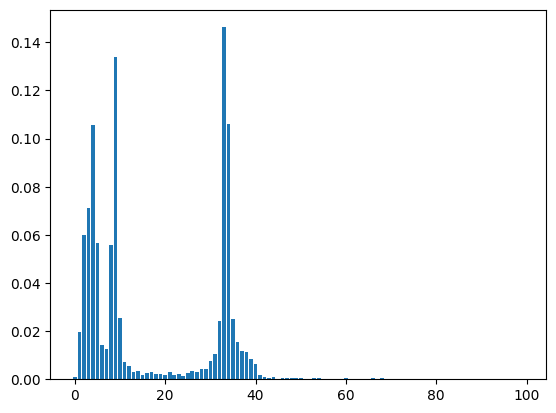

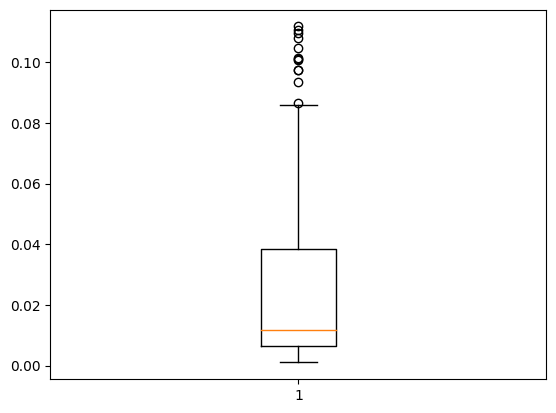

Filter:   0%|          | 0/9000 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/250 [00:00<?, ? examples/s]

[WARNING|modeling_utils.py:3331] 2023-08-18 07:59:41,758 >> Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running tokenizer on dataset:   0%|          | 0/250 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
50,1.055500,0.806471,0.786667
100,0.492700,0.636151,0.795000
150,0.166900,0.689298,0.835000
200,0.059700,1.060354,0.804167
250,0.014600,1.018221,0.831667
300,0.003100,1.072877,0.834167
350,0.008900,1.069389,0.835000
400,0.001700,1.082362,0.833333
450,0.001500,1.085673,0.835000
500,0.001500,1.090235,0.835000


***** train metrics *****
  epoch                    =      31.25
  total_flos               =   478696GF
  train_loss               =     0.1806
  train_runtime            = 0:05:18.24
  train_samples            =        250
  train_samples_per_second =     25.138
  train_steps_per_second   =      1.571


***** eval metrics *****
  epoch                   =      31.25
  eval_accuracy           =      0.835
  eval_loss               =     1.0902
  eval_runtime            = 0:00:08.73
  eval_samples            =       1200
  eval_samples_per_second =    137.377
  eval_steps_per_second   =      8.586
*** predictions: [[-1.9467101  5.992183  -2.3701649 -2.5190728]
 [-2.0554757 -2.0734866 -1.5917037  6.524912 ]
 [ 1.3269085  4.299815  -3.350039  -3.0225213]
 ...
 [-2.004281  -2.0621037 -1.6772288  6.5615654]
 [-2.1007605  5.1711173 -2.9289236 -0.922853 ]
 [-1.8210669  5.8652062 -2.4022086 -2.479472 ]]
*** predictions_len data: 1800


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Metrics Report:

Accuracy: 0.8427777777777777
Confusion Matrix:
[[390  37  16  25]
 [ 91 303   5  49]
 [  5   5 434   9]
 [ 20   6  15 390]]
Precision: 0.8450658953908673
Recall: 0.8427777777777777
F1-score: 0.8402534203773993
Current Active Learning Iteration: 2


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/20 [00:00<?, ?it/s]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   1    |   15    |   1.381095  


  5%|▌         | 1/20 [01:07<21:13, 67.00s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   2    |   15    |   1.295510  


 10%|█         | 2/20 [02:14<20:06, 67.05s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   3    |   15    |   1.260575  


 15%|█▌        | 3/20 [03:20<18:58, 66.95s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   4    |   15    |   1.179046  


 20%|██        | 4/20 [04:27<17:49, 66.86s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   5    |   15    |   1.100801  


 25%|██▌       | 5/20 [05:34<16:42, 66.81s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   6    |   15    |   1.001448  


 30%|███       | 6/20 [06:41<15:34, 66.78s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   7    |   15    |   0.947621  


 35%|███▌      | 7/20 [07:47<14:27, 66.76s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   8    |   15    |   0.873311  


 40%|████      | 8/20 [08:54<13:21, 66.77s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   9    |   15    |   0.828376  


 45%|████▌     | 9/20 [10:01<12:14, 66.76s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  10    |   15    |   0.787221  


 50%|█████     | 10/20 [11:07<11:07, 66.72s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  11    |   15    |   0.760371  


 55%|█████▌    | 11/20 [12:14<10:00, 66.70s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  12    |   15    |   0.761775  


 60%|██████    | 12/20 [13:21<08:54, 66.82s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  13    |   15    |   0.749322  


 65%|██████▌   | 13/20 [14:28<07:47, 66.86s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  14    |   15    |   0.716971  


 70%|███████   | 14/20 [15:35<06:41, 66.86s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  15    |   15    |   0.704592  


 75%|███████▌  | 15/20 [16:42<05:34, 66.85s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  16    |   15    |   0.681827  


 80%|████████  | 16/20 [17:49<04:27, 66.83s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  17    |   15    |   0.683502  


 85%|████████▌ | 17/20 [18:55<03:20, 66.79s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  18    |   15    |   0.689201  


 90%|█████████ | 18/20 [20:02<02:13, 66.74s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  19    |   15    |   0.681148  


 95%|█████████▌| 19/20 [21:09<01:06, 66.73s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  20    |   15    |   0.707000  


100%|██████████| 20/20 [22:15<00:00, 66.79s/it]


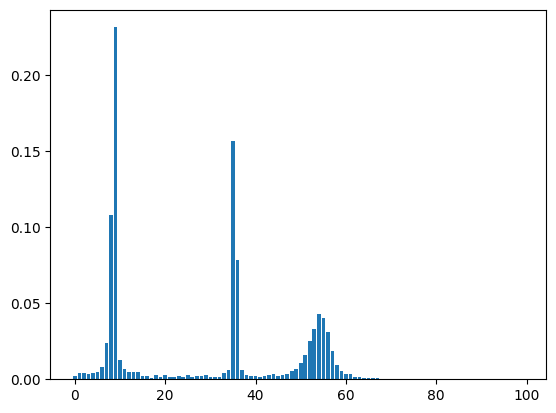

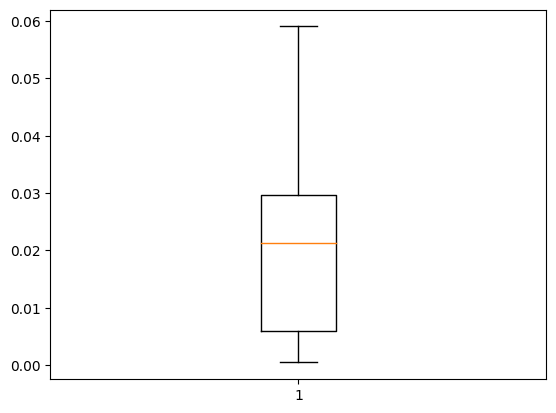

Filter:   0%|          | 0/9000 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/350 [00:00<?, ? examples/s]

[WARNING|modeling_utils.py:3331] 2023-08-18 08:30:13,433 >> Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running tokenizer on dataset:   0%|          | 0/350 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
50,1.097200,0.669568,0.798333
100,0.435200,0.467775,0.855000
150,0.211200,0.661737,0.834167
200,0.087600,0.721558,0.852500
250,0.056800,0.854310,0.844167
300,0.016500,0.923154,0.849167
350,0.002400,0.914021,0.855000
400,0.005600,0.927748,0.854167
450,0.006200,0.955692,0.854167
500,0.001600,0.956959,0.855000


***** train metrics *****
  epoch                    =      22.73
  total_flos               =   487395GF
  train_loss               =      0.192
  train_runtime            = 0:05:16.59
  train_samples            =        350
  train_samples_per_second =     25.269
  train_steps_per_second   =      1.579


***** eval metrics *****
  epoch                   =      22.73
  eval_accuracy           =      0.855
  eval_loss               =      0.957
  eval_runtime            = 0:00:08.66
  eval_samples            =       1200
  eval_samples_per_second =    138.507
  eval_steps_per_second   =      8.657
*** predictions: [[-2.0781388  6.179504  -2.3828034 -2.4451337]
 [-1.9337112 -2.1565917 -1.615243   6.4048095]
 [-0.7477325  5.733215  -3.240974  -2.509479 ]
 ...
 [-1.9046608 -2.15483   -1.6129793  6.431992 ]
 [-2.0897527 -1.1743125 -2.3372743  6.2862797]
 [-1.878517   5.953695  -2.3837817 -2.4822528]]
*** predictions_len data: 1800


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Metrics Report:

Accuracy: 0.8583333333333333
Confusion Matrix:
[[387  47   8  26]
 [ 59 329   3  57]
 [  6   6 432   9]
 [ 15   6  13 397]]
Precision: 0.8593194125702548
Recall: 0.8583333333333333
F1-score: 0.8569846336060447
Current Active Learning Iteration: 3


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/20 [00:00<?, ?it/s]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   1    |   21    |   1.372312  


  5%|▌         | 1/20 [01:14<23:36, 74.55s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   2    |   21    |   1.334381  


 10%|█         | 2/20 [02:29<22:21, 74.54s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   3    |   21    |   1.247213  


 15%|█▌        | 3/20 [03:43<21:05, 74.45s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   4    |   21    |   1.139683  


 20%|██        | 4/20 [04:57<19:50, 74.38s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   5    |   21    |   1.016221  


 25%|██▌       | 5/20 [06:11<18:35, 74.34s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   6    |   21    |   0.963727  


 30%|███       | 6/20 [07:26<17:20, 74.31s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   7    |   21    |   0.889745  


 35%|███▌      | 7/20 [08:40<16:05, 74.31s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   8    |   21    |   0.844020  


 40%|████      | 8/20 [09:54<14:51, 74.31s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   9    |   21    |   0.813315  


 45%|████▌     | 9/20 [11:09<13:37, 74.31s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  10    |   21    |   0.795058  


 50%|█████     | 10/20 [12:23<12:23, 74.36s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  11    |   21    |   0.778108  


 55%|█████▌    | 11/20 [13:37<11:09, 74.36s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  12    |   21    |   0.743082  


 60%|██████    | 12/20 [14:52<09:55, 74.42s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  13    |   21    |   0.724849  


 65%|██████▌   | 13/20 [16:06<08:40, 74.34s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  14    |   21    |   0.732623  


 70%|███████   | 14/20 [17:20<07:25, 74.31s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  15    |   21    |   0.725352  


 75%|███████▌  | 15/20 [18:35<06:11, 74.38s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  16    |   21    |   0.711016  


 80%|████████  | 16/20 [19:49<04:57, 74.35s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  17    |   21    |   0.725062  


 85%|████████▌ | 17/20 [21:04<03:43, 74.42s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  18    |   21    |   0.705326  


 90%|█████████ | 18/20 [22:18<02:28, 74.43s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  19    |   21    |   0.690656  


 95%|█████████▌| 19/20 [23:33<01:14, 74.40s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  20    |   21    |   0.705521  


100%|██████████| 20/20 [24:47<00:00, 74.37s/it]


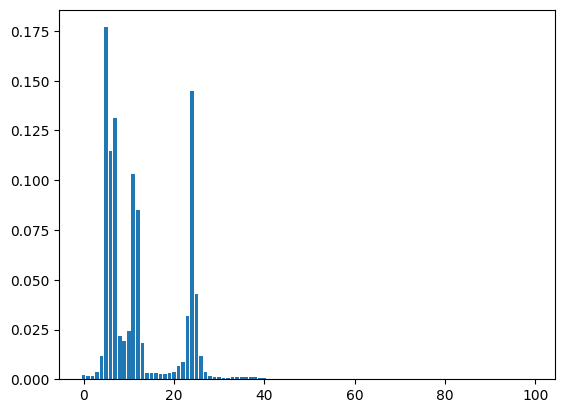

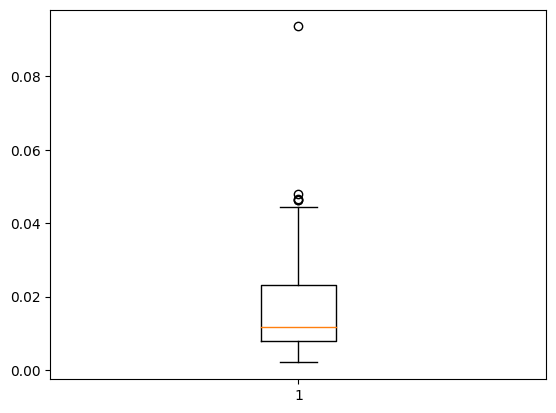

Filter:   0%|          | 0/9000 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/450 [00:00<?, ? examples/s]

[WARNING|modeling_utils.py:3331] 2023-08-18 09:03:17,459 >> Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running tokenizer on dataset:   0%|          | 0/450 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
50,1.126800,0.680763,0.850000
100,0.609100,0.442868,0.855833
150,0.394400,0.477048,0.849167
200,0.213600,0.551917,0.850000
250,0.106300,0.698787,0.854167
300,0.053600,0.727149,0.860833
350,0.030200,0.785592,0.867500
400,0.031100,0.812361,0.865833
450,0.023800,0.835939,0.861667
500,0.017000,0.847327,0.860833


***** train metrics *****
  epoch                    =      17.24
  total_flos               =   475511GF
  train_loss               =     0.2606
  train_runtime            = 0:05:12.71
  train_samples            =        450
  train_samples_per_second =     25.583
  train_steps_per_second   =      1.599


***** eval metrics *****
  epoch                   =      17.24
  eval_accuracy           =     0.8608
  eval_loss               =     0.8473
  eval_runtime            = 0:00:08.64
  eval_samples            =       1200
  eval_samples_per_second =    138.744
  eval_steps_per_second   =      8.671
*** predictions: [[-1.6315387  5.809253  -2.6437106 -2.290335 ]
 [-1.9396999 -2.0512974 -1.2954513  5.9215574]
 [-1.7189951  5.189989  -3.2680223 -0.8851874]
 ...
 [-1.944502  -2.0316443 -1.3126578  6.049826 ]
 [-2.0367463 -1.637334  -1.5926857  6.0434685]
 [-1.4869968  5.638831  -2.60683   -2.416972 ]]
*** predictions_len data: 1800


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Metrics Report:

Accuracy: 0.8594444444444445
Confusion Matrix:
[[371  62   6  29]
 [ 55 355   4  34]
 [  6   4 433  10]
 [ 18  12  13 388]]
Precision: 0.8589109886482683
Recall: 0.8594444444444445
F1-score: 0.8588002263459905
Current Active Learning Iteration: 4


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/20 [00:00<?, ?it/s]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   1    |   28    |   1.323792  


  5%|▌         | 1/20 [01:22<26:05, 82.41s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   2    |   28    |   1.157482  


 10%|█         | 2/20 [02:44<24:40, 82.23s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   3    |   28    |   1.047161  


 15%|█▌        | 3/20 [04:06<23:16, 82.16s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   4    |   28    |   0.972002  


 20%|██        | 4/20 [05:28<21:54, 82.14s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   5    |   28    |   0.898667  


 25%|██▌       | 5/20 [06:50<20:32, 82.14s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   6    |   28    |   0.873070  


 30%|███       | 6/20 [08:13<19:10, 82.16s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   7    |   28    |   0.825671  


 35%|███▌      | 7/20 [09:34<17:47, 82.08s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   8    |   28    |   0.795439  


 40%|████      | 8/20 [10:56<16:24, 82.05s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   9    |   28    |   0.777155  


 45%|████▌     | 9/20 [12:18<15:02, 82.05s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  10    |   28    |   0.720953  


 50%|█████     | 10/20 [13:41<13:40, 82.06s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  11    |   28    |   0.722850  


 55%|█████▌    | 11/20 [15:03<12:18, 82.09s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  12    |   28    |   0.694626  


 60%|██████    | 12/20 [16:25<10:56, 82.10s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  13    |   28    |   0.695234  


 65%|██████▌   | 13/20 [17:47<09:34, 82.09s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  14    |   28    |   0.687129  


 70%|███████   | 14/20 [19:09<08:12, 82.07s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  15    |   28    |   0.638722  


 75%|███████▌  | 15/20 [20:31<06:50, 82.02s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  16    |   28    |   0.655427  


 80%|████████  | 16/20 [21:53<05:28, 82.03s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  17    |   28    |   0.655724  


 85%|████████▌ | 17/20 [23:15<04:06, 82.11s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  18    |   28    |   0.661523  


 90%|█████████ | 18/20 [24:37<02:44, 82.06s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  19    |   28    |   0.648956  


 95%|█████████▌| 19/20 [25:59<01:22, 82.04s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  20    |   28    |   0.655928  


100%|██████████| 20/20 [27:21<00:00, 82.08s/it]


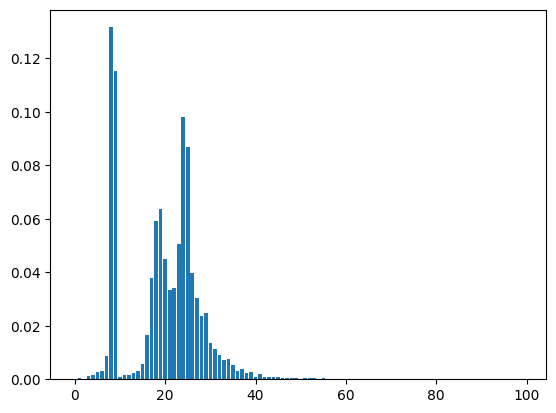

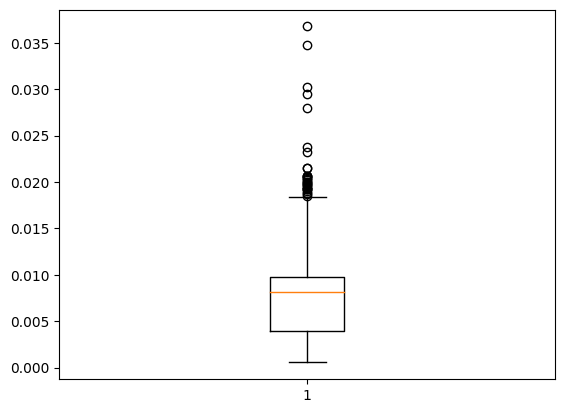

Filter:   0%|          | 0/9000 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/550 [00:00<?, ? examples/s]

[WARNING|modeling_utils.py:3331] 2023-08-18 09:38:49,135 >> Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running tokenizer on dataset:   0%|          | 0/550 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
50,1.175200,0.703275,0.816667
100,0.746600,0.424780,0.865000
150,0.447800,0.442088,0.867500
200,0.249900,0.496616,0.864167
250,0.179200,0.571844,0.864167
300,0.087600,0.602911,0.876667
350,0.049800,0.675117,0.879167
400,0.042000,0.697236,0.876667
450,0.026400,0.725233,0.871667
500,0.023600,0.717718,0.875833


***** train metrics *****
  epoch                    =      14.29
  total_flos               =   481514GF
  train_loss               =     0.3028
  train_runtime            = 0:05:21.26
  train_samples            =        550
  train_samples_per_second =     24.901
  train_steps_per_second   =      1.556


***** eval metrics *****
  epoch                   =      14.29
  eval_accuracy           =     0.8758
  eval_loss               =     0.7177
  eval_runtime            = 0:00:08.67
  eval_samples            =       1200
  eval_samples_per_second =    138.314
  eval_steps_per_second   =      8.645
*** predictions: [[-1.7344164   5.4214053  -2.3011475  -1.8974298 ]
 [-1.8078929  -1.8848552  -1.1217601   5.6214375 ]
 [-1.1746464   5.556131   -2.9782455  -2.1930983 ]
 ...
 [-1.8028574  -1.8892108  -1.217398    5.7160497 ]
 [-2.1205912   4.5165854  -3.5814795   0.70099914]
 [-1.7457196   5.52968    -2.4030926  -1.9618688 ]]
*** predictions_len data: 1800


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Metrics Report:

Accuracy: 0.8711111111111111
Confusion Matrix:
[[387  54   6  21]
 [ 56 357   4  31]
 [  6   4 433  10]
 [ 19  10  11 391]]
Precision: 0.8707651627967786
Recall: 0.8711111111111111
F1-score: 0.8706651839086568
Current Active Learning Iteration: 5


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/20 [00:00<?, ?it/s]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   1    |   34    |   1.391890  


  5%|▌         | 1/20 [01:30<28:32, 90.14s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   2    |   34    |   1.307767  


 10%|█         | 2/20 [03:00<26:59, 90.00s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   3    |   34    |   1.195013  


 15%|█▌        | 3/20 [04:29<25:28, 89.91s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   4    |   34    |   1.070778  


 20%|██        | 4/20 [05:59<23:55, 89.72s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   5    |   34    |   1.002368  


 25%|██▌       | 5/20 [07:27<22:20, 89.34s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   6    |   34    |   0.943298  


 30%|███       | 6/20 [08:56<20:47, 89.10s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   7    |   34    |   0.878950  


 35%|███▌      | 7/20 [10:25<19:15, 88.89s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   8    |   34    |   0.799661  


 40%|████      | 8/20 [11:53<17:44, 88.74s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   9    |   34    |   0.796035  


 45%|████▌     | 9/20 [13:21<16:14, 88.61s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  10    |   34    |   0.781354  


 50%|█████     | 10/20 [14:50<14:45, 88.52s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  11    |   34    |   0.740904  


 55%|█████▌    | 11/20 [16:18<13:16, 88.50s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  12    |   34    |   0.708202  


 60%|██████    | 12/20 [17:46<11:47, 88.39s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  13    |   34    |   0.703567  


 65%|██████▌   | 13/20 [19:14<10:18, 88.31s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  14    |   34    |   0.711743  


 70%|███████   | 14/20 [20:42<08:49, 88.27s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  15    |   34    |   0.695037  


 75%|███████▌  | 15/20 [22:11<07:21, 88.34s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  16    |   34    |   0.707501  


 80%|████████  | 16/20 [23:39<05:53, 88.32s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  17    |   34    |   0.720896  


 85%|████████▌ | 17/20 [25:07<04:24, 88.29s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  18    |   34    |   0.714118  


 90%|█████████ | 18/20 [26:36<02:56, 88.29s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  19    |   34    |   0.715488  


 95%|█████████▌| 19/20 [28:04<01:28, 88.22s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  20    |   34    |   0.700249  


100%|██████████| 20/20 [29:32<00:00, 88.62s/it]


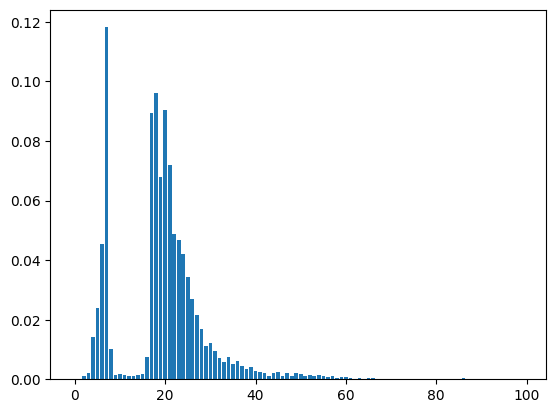

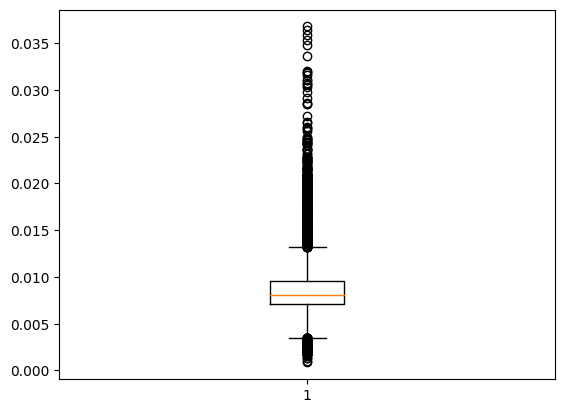

Filter:   0%|          | 0/9000 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/650 [00:00<?, ? examples/s]

[WARNING|modeling_utils.py:3331] 2023-08-18 10:16:35,094 >> Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running tokenizer on dataset:   0%|          | 0/650 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
50,1.203300,0.812145,0.698333
100,0.768500,0.451495,0.866667
150,0.566200,0.398957,0.881667
200,0.345100,0.444790,0.874167
250,0.244400,0.486996,0.875000
300,0.152800,0.540675,0.875833
350,0.109300,0.607841,0.876667
400,0.074400,0.627639,0.876667
450,0.040900,0.666301,0.874167
500,0.040100,0.676696,0.875000


***** train metrics *****
  epoch                    =       12.2
  total_flos               =   485680GF
  train_loss               =     0.3545
  train_runtime            = 0:05:10.70
  train_samples            =        650
  train_samples_per_second =     25.748
  train_steps_per_second   =      1.609


***** eval metrics *****
  epoch                   =       12.2
  eval_accuracy           =      0.875
  eval_loss               =     0.6767
  eval_runtime            = 0:00:08.28
  eval_samples            =       1200
  eval_samples_per_second =    144.849
  eval_steps_per_second   =      9.053
*** predictions: [[-1.6083184  5.392491  -2.6789212 -1.8800669]
 [-2.034896  -1.8330023 -1.2913588  5.3729234]
 [-1.295935   5.319937  -3.0188706 -1.7561032]
 ...
 [-1.9803612 -1.7882386 -1.3217176  5.4056625]
 [-2.5422206  4.233578  -3.0715518  1.0646715]
 [-1.6363746  5.1599307 -2.414231  -1.8981748]]
*** predictions_len data: 1800


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Metrics Report:

Accuracy: 0.8833333333333333
Confusion Matrix:
[[396  48   7  17]
 [ 48 367   5  28]
 [  6   4 435   8]
 [ 16  12  11 392]]
Precision: 0.882829842388827
Recall: 0.8833333333333333
F1-score: 0.8829408209611569
Current Active Learning Iteration: 6


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/20 [00:00<?, ?it/s]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   1    |   40    |   1.455516  


  5%|▌         | 1/20 [01:33<29:41, 93.76s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   2    |   40    |   1.257763  


 10%|█         | 2/20 [03:08<28:16, 94.23s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   3    |   40    |   1.073233  


 15%|█▌        | 3/20 [04:43<26:48, 94.60s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   4    |   40    |   0.979853  


 20%|██        | 4/20 [06:18<25:19, 94.99s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   5    |   40    |   0.929292  


 25%|██▌       | 5/20 [07:54<23:46, 95.11s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   6    |   40    |   0.892463  


 30%|███       | 6/20 [09:29<22:11, 95.14s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   7    |   40    |   0.825751  


 35%|███▌      | 7/20 [11:04<20:37, 95.21s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   8    |   40    |   0.782540  


 40%|████      | 8/20 [12:40<19:03, 95.28s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   9    |   40    |   0.783977  


 45%|████▌     | 9/20 [14:15<17:29, 95.41s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  10    |   40    |   0.751672  


 50%|█████     | 10/20 [15:51<15:54, 95.44s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  11    |   40    |   0.723791  


 55%|█████▌    | 11/20 [17:26<14:19, 95.45s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  12    |   40    |   0.724276  


 60%|██████    | 12/20 [19:03<12:46, 95.87s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  13    |   40    |   0.723218  


 65%|██████▌   | 13/20 [20:41<11:14, 96.32s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  14    |   40    |   0.731380  


 70%|███████   | 14/20 [22:18<09:39, 96.54s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  15    |   40    |   0.731285  


 75%|███████▌  | 15/20 [23:55<08:03, 96.65s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  16    |   40    |   0.727059  


 80%|████████  | 16/20 [25:31<06:26, 96.72s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  17    |   40    |   0.731021  


 85%|████████▌ | 17/20 [27:08<04:50, 96.81s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  18    |   40    |   0.722938  


 90%|█████████ | 18/20 [28:45<03:13, 96.87s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  19    |   40    |   0.720799  


 95%|█████████▌| 19/20 [30:23<01:36, 96.94s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  20    |   40    |   0.720058  


100%|██████████| 20/20 [32:00<00:00, 96.01s/it]


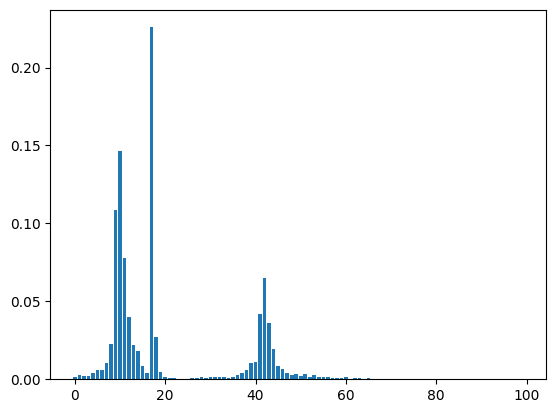

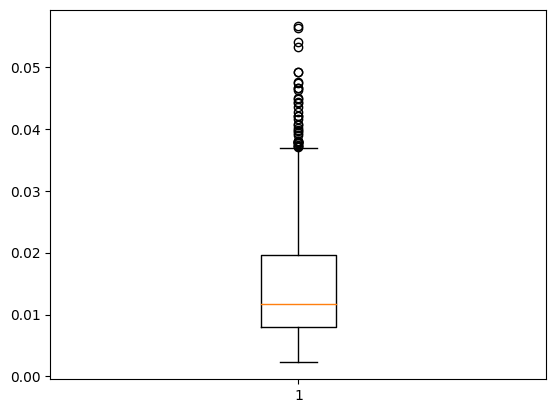

Filter:   0%|          | 0/9000 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/750 [00:00<?, ? examples/s]

[WARNING|modeling_utils.py:3331] 2023-08-18 10:56:41,216 >> Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running tokenizer on dataset:   0%|          | 0/750 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
50,1.232200,0.764803,0.753333
100,0.822400,0.426281,0.879167
150,0.582000,0.381201,0.892500
200,0.459400,0.386529,0.881667
250,0.269700,0.436039,0.880833
300,0.210100,0.506479,0.867500
350,0.116600,0.533668,0.875000
400,0.066300,0.608113,0.873333
450,0.066000,0.606088,0.880833
500,0.034800,0.620177,0.885833


***** train metrics *****
  epoch                    =      10.64
  total_flos               =   488866GF
  train_loss               =      0.386
  train_runtime            = 0:05:22.64
  train_samples            =        750
  train_samples_per_second =     24.795
  train_steps_per_second   =       1.55


***** eval metrics *****
  epoch                   =      10.64
  eval_accuracy           =     0.8858
  eval_loss               =     0.6202
  eval_runtime            = 0:00:08.61
  eval_samples            =       1200
  eval_samples_per_second =    139.358
  eval_steps_per_second   =       8.71
*** predictions: [[-1.647714   5.0485864 -2.2863655 -1.8348278]
 [-1.7902491 -1.8727047 -1.0472388  4.8864636]
 [-1.3519794  4.9505925 -2.4497776 -1.9206456]
 ...
 [-1.8433506 -2.056321  -1.1079668  5.4106855]
 [-2.0760906  3.5168982 -2.8022747  0.9122699]
 [-1.6459252  4.914705  -2.0556083 -1.9439443]]
*** predictions_len data: 1800


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Metrics Report:

Accuracy: 0.8811111111111111
Confusion Matrix:
[[402  50   5  11]
 [ 59 364   7  18]
 [  7   3 435   8]
 [ 24  10  12 385]]
Precision: 0.8815647273393505
Recall: 0.8811111111111111
F1-score: 0.8810479397448291


In [43]:
# model, head = run_discrepancy_sampling()
run_discrepancy_sampling()

In [44]:
torch.save(model, "./results/model.pt")
torch.save(head, "./results/head.pt")

NameError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
! mv ./results/discrepancy/ ./drive/MyDrive/Thesis/Data/experiments/

### Test Model

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, do_lower_case=True)

In [ ]:
def is_political(sentence, base_model, classifier):
    input = tokenizer.encode_plus(
                sentence,                      # Sentence to encode.
                add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                max_length = 256,           # Pad & truncate all sentences.
                pad_to_max_length = True,
                return_attention_mask = True,   # Construct attn. masks.
                return_tensors = 'pt',     # Return pytorch tensors.
        ).to(DEVICE)
    outputs = base_model(**input)
    last_hidden_state_cls = outputs[0][:, 0, :].to(DEVICE)

    logits = classifier(last_hidden_state_cls)

    is_political = torch.argmax(logits, dim=1).flatten().item()

    if is_political == 0:
        return "👎"
    else:
        return "👍"

In [ ]:
is_political("زندانیان سیاسی را آزاد کنید.", base_model=model, classifier=head)

In [ ]:
is_political("راهمپیمایی امروز نشان دهنده قدرت نظام بود.", base_model=model, classifier=head)

In [ ]:
is_political("زندانیان جرائم سیاسی را باید آزاد کرد", base_model=model, classifier=head)